In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skmob
from skmob.tessellation import tilers
from skmob.measures.individual import distance_straight_line, maximum_distance, number_of_visits, waiting_times, real_entropy
import math
from tqdm import tqdm
from numpy.linalg import norm
import traja
from scipy.stats import ks_2samp
import folium
from datetime import datetime
from skmob.models.epr import DensityEPR
import geopandas as gpd


/home/ryn/anaconda3/lib/python3.8/site-packages/tqdm/std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [170]:
def get_speed(traj):
    f_np = np.asarray(traj)
    xs = np.subtract(f_np[0:-1,0],f_np[1:,0])
    ys = np.subtract(f_np[0:-1,1],f_np[1:,1])
    speed = np.divide(np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2))),np.subtract(f_np[1:,2],f_np[:-1,2]))
    speed = np.insert(speed, 0,0)
    if(len(speed) != 1500):
        print("HERE!", np.shape(speed[0]))
    return speed

def get_acc(traj):
    f_np = np.asarray(traj)
    acc = np.divide(np.subtract(f_np[1:,6], f_np[:-1,6]),np.subtract(f_np[1:,4],f_np[:-1,4]))
    acc = np.insert(acc, 0,0)
    return acc

def get_angle(traj):
    f_np = np.asarray(traj)
    angle = np.arctan2(np.subtract(f_np[0:-1,3],f_np[1:,3]),np.subtract(f_np[0:-1,2],f_np[1:,2]))
    angle = np.insert(angle, 0,0)
    deg = [math.degrees(x) for x in angle]
    return deg

def get_speed_rw(traj):
    f_np = np.asarray(traj)
    xs = np.subtract(f_np[0:-1,0],f_np[1:,0])
    ys = np.subtract(f_np[0:-1,1],f_np[1:,1])
    speed = np.divide(np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2))),np.subtract(f_np[1:,2],f_np[:-1,2]))
    speed = np.insert(speed, 0,0)
    if(len(speed) != 1500):
        print("HERE!", np.shape(speed[0]))
    return speed

def get_acc_rw(traj):
    f_np = np.asarray(traj)
    xs = np.subtract(f_np[0:-1,0],f_np[1:,0])
    ys = np.subtract(f_np[0:-1,1],f_np[1:,1])
    speed = np.divide(np.sqrt(np.add(np.power(xs, 2), np.power(ys, 2))),np.subtract(f_np[1:,2],f_np[:-1,2]))
    speed = np.insert(speed, 0,0)   
    acc = np.divide(np.subtract(speed[1:], speed[:-1]),np.subtract(f_np[1:,2],f_np[:-1,2]))
    acc = np.insert(acc, 0,0)
    return acc

def get_angle_rw(traj, convert_to_degrees = False):
    f_np = np.asarray(traj)
    angle = np.arctan2(np.subtract(f_np[0:-1,1],f_np[1:,1]),np.subtract(f_np[0:-1,0],f_np[1:,0]))
    angle = np.insert(angle, 0,0)
    if(convert_to_degrees):
        deg = [math.degrees(x) for x in angle]
    else:
        deg = angle
    return deg

def get_change_dir(a):
    a = np.asarray(a)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    signchange[0]=0
    return sum(signchange)

def triangle_area(arr, step_size = 1):
    if(step_size == 0):
        print("Cannot have step size be 0")
    tot_area = 0
    for i in range(len(arr)):
        [x1,y1,t] = arr[i]
        [x2,y2,t] = arr[i+step_size]
        try:
            [x3,y3,t] = arr[i+2*step_size]
        except:
            return tot_area
        Area = 1/2 *(x1*abs(y2 - y3) + x2*abs(y3 - y1) + x3*abs(y1 - y2))
        tot_area += Area
    return tot_area

In [3]:
dat = pd.read_csv("../../Minute_Trajectories_3.csv")
# dat['angles'] = traja.trajectory.calc_angle(dat)

In [51]:
dat_avg = pd.read_csv("overview_minute.csv")

In [4]:
datnp = np.asarray(dat)

In [35]:
dat.loc[3,['x','y']] 

x    2085.9320
y     662.4187
Name: 3, dtype: float64

In [6]:
dat['x'][0]

2085.328

In [7]:
print(dat.head())

   minute_id         x         y       t   id       tmp
0          1  2085.328  662.2738  304.08  1.0       NaN
1          1  2085.488  662.2914  304.12  1.0  0.040009
2          1  2085.695  662.3420  304.16  1.0  0.040009
3          1  2085.932  662.4187  304.20  1.0  0.040009
4          1  2086.202  662.5214  304.24  1.0  0.039978


In [8]:
def return_mult():
    return [1,2,3]

a = return_mult()
a

[1, 2, 3]

In [195]:
def sample_angle_unif():
    return np.random.uniform(low=0, high=2*np.pi)

def sample_angle_data():
    return dat.sample(n=1)['angles']#math.radians(dat.sample(n=1)['angles'])

def sample_angle_norm():
    return np.random.normal(0,100)

def sample_angle_beta():
    return 50*(np.random.beta(2,2)-0.5)

In [196]:
def sample_length_unif():
    return np.random.uniform(low=0, high = 1)
def sample_length_data():
    ind = np.random.randint(np.shape(dat)[0])
    if(ind > 0):
        d1 = dat.iloc[ind]
        d2 = dat.iloc[ind-1]
        d = np.sqrt((d1['x']-d2['x'])**2 + (d1['y']-d2['y'])**2)
    else:
        d = 0
    return d
def sample_length_norm():
    return abs(np.random.normal(0,6))


In [215]:
def sample_rw(n=1500,x=0,y=0, a="unif",l="unif"):
    traj = np.zeros((n,3))
    a_old = 0 
    for i in range(1,n):
        if(a == "unif"):
            an = sample_angle_unif()
        elif(a == "data"):
            an = sample_angle_data()
        elif(a == "norm"):
            an = sample_angle_norm()
        elif(a == "beta"):
            an = sample_angle_beta()
        else:
            print("Unknown Option for a")
        if(l == "unif"):
            ln = sample_length_unif()
        elif(l == "data"):
            ln = sample_length_data()
        elif(l == "norm"):
            ln = sample_length_norm()
        else:
            print("Unknown Option for l")
        an_final = np.radians(an + a_old % 360)
        a_old = an
        x1 = traj[i-1][0] + ln * np.cos(an_final)
        y1 = traj[i-1][1] + ln * np.sin(an_final)
        traj[i]=[x1,y1,i]
    return traj
        

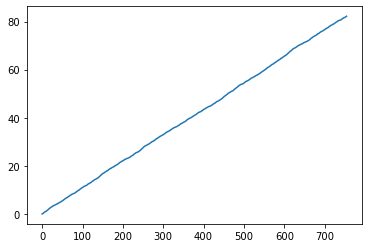

In [216]:
traj = sample_rw()

plt.plot(traj[:,0],traj[:,1])

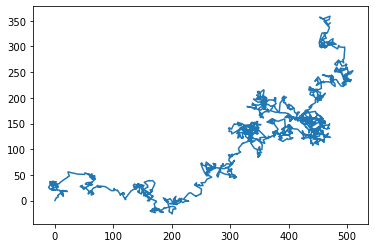

In [217]:
traj = sample_rw(a = "norm", l="norm")

plt.plot(traj[:,0],traj[:,1])

In [218]:
num_generate=4000

In [219]:
random_walks = []
for i in tqdm(range(num_generate)):
    random_walks.append(sample_rw(a="norm",l="norm"))

100%|██████████| 4000/4000 [01:14<00:00, 53.46it/s]


In [224]:
random_walks = np.asarray(random_walks)

In [225]:
print(np.shape(random_walks))


(4000, 1500, 3)


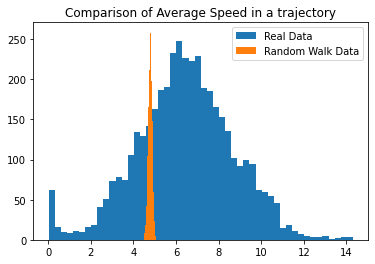

In [226]:
rw_speed = []

for i in range(num_generate):
    rs_tmp = get_speed_rw(random_walks[i,:,:])
    rw_speed.append(np.mean(rs_tmp))
# rw_speed  = [item for sublist in s for item in sublist]


plt.hist(dat_avg['average_speed'],bins = 50, label="Real Data")
plt.hist(rw_speed, bins= 50, label="Random Walk Data")
plt.title("Comparison of Average Speed in a trajectory")
plt.legend()
plt.savefig("speed_rw.png")

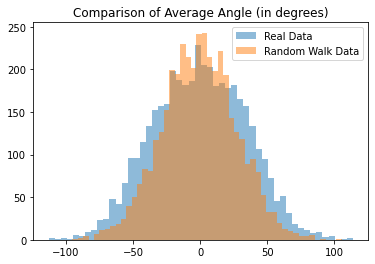

In [231]:
rw_ang = []

for i in range(num_generate):
    rs_tmp = get_angle_rw(random_walks[i,:,:], convert_to_degrees = True)
    rw_ang.append(10*np.mean(rs_tmp))
# rw_speed  = [item for sublist in s for item in sublist]

plt.hist(dat_avg['average_angle'],bins = 50, label="Real Data",alpha=0.5)
plt.hist(rw_ang, bins= 50, label="Random Walk Data",alpha=0.5)
plt.title("Comparison of Average Angle (in degrees)")
plt.legend()
plt.savefig("angle_rw.png")

In [232]:
rw_ind = [i for i in range(num_generate) for j in range(1500)]
rw_ind = np.reshape(rw_ind, (len(rw_ind),1))
rw_reshape = np.reshape(random_walks, (1500*num_generate, 3))
all_data = np.append(rw_reshape, rw_ind, 1)
all_data[:,2] = all_data[:,2]*100

rw_pd = pd.DataFrame(all_data, columns=["x",'y','t','user'])
# rw_pd = pd.Dataframe(all_data, latitude=1, longitude=2, datetime=3, user_id=4)

tdf = skmob.TrajDataFrame(rw_pd, latitude='x',longitude='y',datetime='t',user_id='user')



100%|██████████| 4000/4000 [00:38<00:00, 104.00it/s]


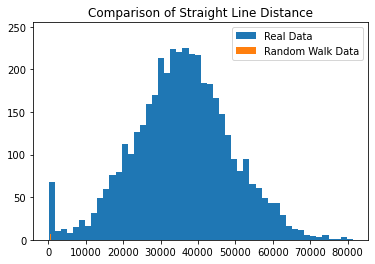

In [235]:
dsl_df = distance_straight_line(tdf)

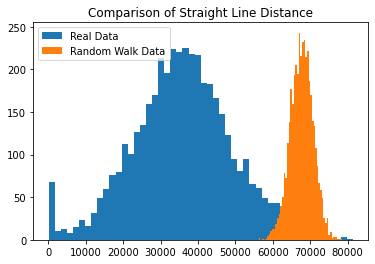

In [256]:
plt_data = dsl_df['distance_straight_line']*100
plt.hist(dat_avg['dist_traveled'],bins=50, label="Real Data")
plt.hist(plt_data,bins=50, label="Random Walk Data")
plt.title("Comparison of Straight Line Distance")
plt.legend()
plt.savefig("line_dist_rw.png")

In [237]:
md_df = maximum_distance(tdf)


100%|██████████| 4000/4000 [00:39<00:00, 101.31it/s]


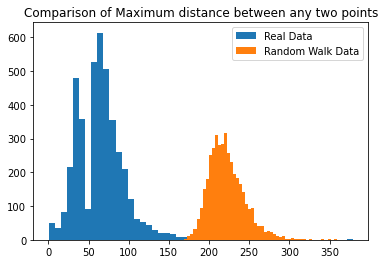

In [243]:
plt_data = md_df['maximum_distance']
plt.hist(dat_avg['max_dist'],bins=50, label="Real Data")
plt.hist(plt_data,bins=50, label="Random Walk Data")
plt.title("Comparison of Maximum distance between any two points")
plt.legend()
plt.savefig("max_dist_rw.png")

In [257]:
d_sl = []
step_size = 50
for i in tqdm(range(num_generate)):
    d_tmp = 0
    for j in range(1,1499,step_size):
        p1 = rw_pd[rw_pd['user']==i].iloc[0][['x','y']]
        p2 = rw_pd[rw_pd['user']==i].iloc[1499][['x','y']]
        p3 = rw_pd[rw_pd['user']==i].iloc[j][['x','y']]
        d_tmp += norm(np.cross(p2-p1, p1-p3))/norm(p2-p1)
    d_sl.append(d_tmp)
    
plt.hist(dat_avg['dist_to_line'],bins=50, label="Real Data")
plt.hist(d_sl, bins=50, label="Random Walk Data")
plt.title("Comparison of Distance to a straight line")
plt.legend()
plt.savefig("max_dist_rw.png")

  9%|▊         | 344/4000 [06:12<1:05:59,  1.08s/it]


KeyboardInterrupt: 

In [ ]:
dc = []
for i in tqdm(range(num_generate)):
    ang = get_angle_rw(np.asarray(rw_pd[rw_pd['user']==i]))
    dc.append(get_change_dir(ang))
    
    
    
plt.hist(dat_avg['direction_changes'],bins=50, label="Real Data")
plt.hist(dc,bins=50, label="Random Walk Data")
plt.title("Comparison of Direction Changes")
plt.legend()
plt.savefig("dir_changes_rw.png")